<a href="https://colab.research.google.com/github/BhyllionSolomon/Robotmato_Project/blob/main/tomatoclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9983 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 1.0000 - loss: 8.8719e-35 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 1.4213e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 1.2030e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 1.7605e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 1.4213e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 1.0000 - loss: 1.4213e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accura

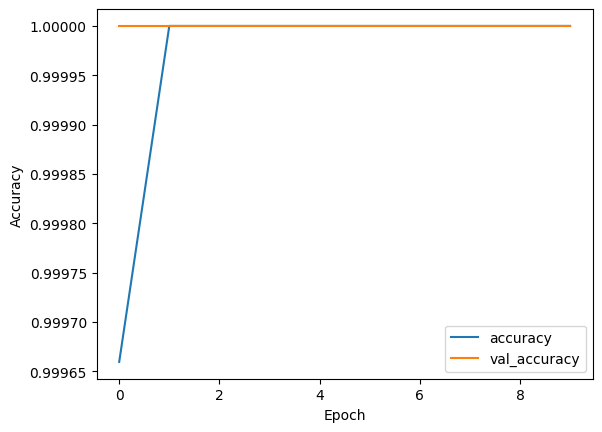

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Download the dataset (ripe/unripe tomatoes)
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('tomato_photos', origin=dataset_url, untar=True)

# Load images
img_height = 180
img_width = 180
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Build the CNN model
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (ripe/unripe)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Save the trained model
model.save("tomato_classifier.h5")

# Plot accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

print(os.listdir("/content/drive/My Drive"))


['216882_OlagunjuKoredeSolomon-compressed.pptx', '216882_OlagunjuKoredeSolomon-Submission.pptx', 'WorkersCompClaim1.pdf', 'WorkersCompClaim1.gdoc', 'Group 2_ November_REPORT 2024.xlsx', 'Group 2_ December_REPORT 2024.xlsx', 'Group 2_ December_REPORT 2024.pdf', 'phd', '2024_KDU_1_EXAM', 'CSC 313_ EXAMSQuestions.docx', 'KDU_FILES', 'CSC 309_ExamQuestions.gdoc', 'Cong_Brothers.gdoc', 'NGO Application.gdoc', '2024_AnifalajeCong Group Arrangement_Updated2.docx', 'CSC 313 ExamGuide.gdoc', 'KDU_CSC 201_Exam Guide (1).gdoc', 'KDU_CSC 201_Exam Question.gdoc', 'KDU_CSC 201_Exam Guide.gdoc', 'SEN 301 Exam Question.gdoc', 'SEN 419 EXAM GUIDE.gdoc', 'SEN 425_ Exam Guide.gdoc', 'SEN 425 EXAM Qeustions.gdoc', 'CSC 313 Exam Question.gdoc', 'CYB 305 Exam Guide.gdoc', 'CYB 305 ExamQuestions.gdoc', 'SEN 419 ExamQuestions.gdoc', 'SEN 419.gdoc', 'Optimizing Energy Usage.gdoc', 'Untitled document.gdoc', 'CSC 309_Score.gdoc', 'Colab Notebooks', 'TomatoDataset']


In [ ]:
dataset_path = "/content/drive/My Drive/TomatoDataset/Tomato"


In [ ]:
import os

print(os.listdir("/content/drive/My Drive/TomatoDataset"))  # Should show ['Tomato']
print(os.listdir(dataset_path))  # Should show ['Ripe', 'Unripe']


['Tomato']
['Ripe', 'Unripe']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1288 images belonging to 2 classes.
Found 322 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 740ms/step - accuracy: 0.9644 - loss: 0.1108
Test Accuracy: 96.27%


In [ ]:
import glob

# Search for the model file in all directories
print(glob.glob("/content/**/*.h5", recursive=True))  # Looks for .h5 files


[]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Search for the model file
!find /content/drive/MyDrive -name "tomato_classifier.h5"


Mounted at /content/drive


In [ ]:
!find /content/drive/MyDrive -name "tomato_classifier.h5"


In [ ]:
!ls /content/drive/MyDrive


'2024_AnifalajeCong Group Arrangement_Updated2.docx'  'KDU_CSC 201_Exam Guide.gdoc'
 2024_KDU_1_EXAM				      'KDU_CSC 201_Exam Question.gdoc'
 216882_OlagunjuKoredeSolomon-compressed.pptx	       KDU_FILES
 216882_OlagunjuKoredeSolomon-Submission.pptx	      'NGO Application.gdoc'
'Colab Notebooks'				      'Optimizing Energy Usage.gdoc'
 Cong_Brothers.gdoc				       phd
'CSC 309_ExamQuestions.gdoc'			      'SEN 301 Exam Question.gdoc'
'CSC 309_Score.gdoc'				      'SEN 419 EXAM GUIDE.gdoc'
'CSC 313 ExamGuide.gdoc'			      'SEN 419 ExamQuestions.gdoc'
'CSC 313 Exam Question.gdoc'			      'SEN 419.gdoc'
'CSC 313_ EXAMSQuestions.docx'			      'SEN 425_ Exam Guide.gdoc'
'CYB 305 Exam Guide.gdoc'			      'SEN 425 EXAM Qeustions.gdoc'
'CYB 305 ExamQuestions.gdoc'			       TomatoDataset
'Group 2_ December_REPORT 2024.pdf'		      'Untitled document.gdoc'
'Group 2_ December_REPORT 2024.xlsx'		       WorkersCompClaim1.gdoc
'Group 2_ November_REPORT 2024.xlsx'		       WorkersCompClaim1.pdf
'KDU_C

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/TomatoDataset/tomato_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/TomatoDataset"))


['Tomato', 'tomato_model.h5']


In [ ]:
import tensorflow as tf

model_path = "/content/drive/MyDrive/TomatoDataset/tomato_model.h5"
model = tf.keras.models.load_model(model_path, compile=False)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
pip install flask flask-cors opencv-python tensorflow numpy


In [ ]:
from flask import Flask, render_template, request, jsonify
import tensorflow as tf
import numpy as np
import cv2
import base64
from io import BytesIO
from PIL import Image

app = Flask(__name__)

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/TomatoDataset/tomato_model.h5")
class_names = ["Ripe Tomato", "Rotten Tomato"]

def preprocess_image(image):
    image = cv2.resize(image, (100, 100))  # Resize to match model input size
    image = np.array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    image_data = data['image']

    # Decode base64 image
    image_bytes = base64.b64decode(image_data.split(',')[1])
    image = Image.open(BytesIO(image_bytes))
    image = np.array(image)

    # Process and predict
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    class_index = np.argmax(prediction)
    result = class_names[class_index]

    return jsonify({'result': result})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import gradio as gr

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/TomatoDataset/tomato_model.h5")

# Define class labels
class_labels = ["Ripe Tomato", "Unripe Tomato"]

# Function to process image and predict
def classify_tomato(image):
    image = cv2.resize(image, (150, 150))  # Resize to match model input size
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    prediction = model.predict(image)
    class_index = np.argmax(prediction)
    return class_labels[class_index]

# Create a simple web interface using Gradio
app = gr.Interface(fn=classify_tomato, inputs="image", outputs="label")
app.launch(share=True)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import gradio as gr

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/TomatoDataset/tomato_model.h5")

# Define class labels
class_labels = ["Ripe Tomato", "Unripe Tomato"]

# Function to process image and predict
def classify_tomato(image):
    image = cv2.resize(image, (150, 150))  # Resize to match model input size
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    prediction = model.predict(image)
    class_index = np.argmax(prediction)
    return class_labels[class_index]

# Create a simple web interface using Gradio
app = gr.Interface(fn=classify_tomato, inputs="image", outputs="label")

# **Force showing the link**
app.launch(share=True, debug=True)




In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

# Check if the file exists
file_path = '/content/drive/MyDrive/TomatoDataset/tomato_model.h5'
if os.path.exists(file_path):
    print("File exists!")
else:
    print("File does not exist. Please check the path.")

File exists!


In [7]:
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/MyDrive/TomatoDataset/tomato_model.h5'
model = load_model(model_path)
print("Model loaded successfully!")

Model loaded successfully!


In [11]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# JavaScript code to capture an image from the webcam
def capture_image():
    js = Javascript('''
        async function capture() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', 0.8);
        }
        ''')
    display(js)
    data = eval_js('capture()')
    binary = b64decode(data.split(',')[1])
    return binary

# Test capturing an image
image_bytes = capture_image()
print("Image captured successfully!")

<IPython.core.display.Javascript object>

Image captured successfully!
